In [1]:
import joblib, tqdm, torch

import numpy as np

from model.classifier import Classifier
from utils.trainer import train
from utils.dataloader import split
from utils.get_labels import label_pts
from utils.generate_data import xmin, xmax, ymin, ymax, b1, b2

import matplotlib.pyplot as plt
plt.style.use('bmh')

# Load data

We define a synthetic dataset with 3 classes over a 2-D feature space.

The boundaries of the dataset can be seen below:

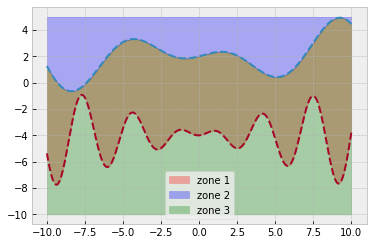

In [2]:
data = joblib.load('data/dataset_init.pt')

x = np.linspace(xmin, xmax, 1000)

bound1 = b1(x)
bound2 = b2(x)

plt.figure()
plt.plot(x, bound1, '--', label='_nolegend_')
plt.plot(x, bound2, '--', label='_nolegend_')

plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)

plt.legend(['zone 1', 'zone 2', 'zone 3'])
plt.show()


Our goal is to learn an accurate classification rule from data that can be sampled in the space.

Let's say we start off with a labeled dataset such as the following :

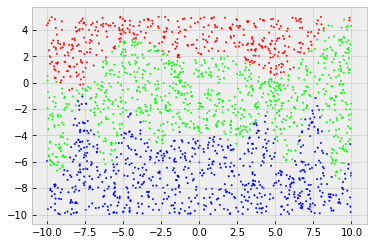

In [3]:
cloud = data['x']
labels = data['y']

plt.figure()
plt.scatter(cloud[:, 0], cloud[:, 1], c = labels, s = 2)
plt.show()

Clearly, this data is not enough to model transition boundaries with high precision, so the goal is to progressivey augment the dataset with samples that are close the boundaries in an Active learning framework.

Let's start with a classical training of the model.

In [5]:
data_train, data_test = split(data, perc = .75)

model = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model.device = 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model, data_train, data_test, optimizer, criterion, active= False, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
metrics2 = train(model, data_train, data_test, optimizer, criterion, active = False, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))


  0%|          | 1/300 [00:03<15:05,  3.03s/it]

epoch : 0 - L_train : 0.012944393754005433 - L_val : 0.012283856034278869


 17%|█▋        | 52/300 [00:35<01:25,  2.91it/s]

epoch : 50 - L_train : 0.010709376136461893 - L_val : 0.010977478861808778


 34%|███▎      | 101/300 [01:06<01:38,  2.03it/s]

epoch : 100 - L_train : 0.010294925729433696 - L_val : 0.0107135249376297


 50%|█████     | 151/300 [01:21<00:32,  4.63it/s]

epoch : 150 - L_train : 0.010387992779413859 - L_val : 0.011467814683914184


 67%|██████▋   | 201/300 [01:33<00:19,  5.19it/s]

epoch : 200 - L_train : 0.010245636026064556 - L_val : 0.010710548758506775


 84%|████████▍ | 252/300 [01:47<00:09,  5.09it/s]

epoch : 250 - L_train : 0.01033454410235087 - L_val : 0.010744379878044129


  0%|          | 0/400 [00:00<?, ?it/s]

Done training.


  0%|          | 1/400 [00:00<04:00,  1.66it/s]

epoch : 0 - L_train : 0.010861548582712809 - L_val : 0.011092840671539306


 13%|█▎        | 51/400 [00:13<01:00,  5.76it/s]

epoch : 50 - L_train : 0.01005608332157135 - L_val : 0.010738077282905578


 26%|██▌       | 102/400 [00:23<00:59,  5.01it/s]

epoch : 100 - L_train : 0.010042341510454814 - L_val : 0.010690350413322449


 38%|███▊      | 151/400 [00:35<01:39,  2.50it/s]

epoch : 150 - L_train : 0.010021528482437134 - L_val : 0.01063452661037445


 50%|█████     | 201/400 [00:53<00:54,  3.62it/s]

epoch : 200 - L_train : 0.0100049463113149 - L_val : 0.010641183257102966


 63%|██████▎   | 251/400 [01:05<00:34,  4.34it/s]

epoch : 250 - L_train : 0.009993522604306538 - L_val : 0.010652069330215454


 76%|███████▌  | 302/400 [01:16<00:18,  5.33it/s]

epoch : 300 - L_train : 0.00998660377661387 - L_val : 0.010659095048904419


 88%|████████▊ | 351/400 [01:25<00:14,  3.44it/s]

epoch : 350 - L_train : 0.010025787154833475 - L_val : 0.010615880370140076


100%|██████████| 400/400 [01:43<00:00,  3.86it/s]

Done training.


We can clearly see that the model fails to learn the correct boundary, especially since more importance is given to data that is not along the boundaries, which is therefore more numerous and frequent during the training process.

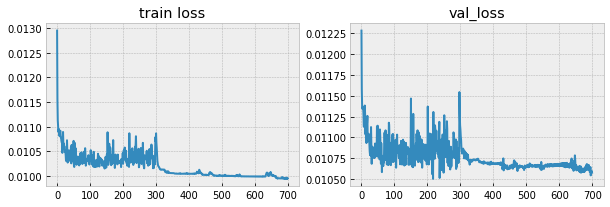

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Let's see how well the model is able to separate th different domains.

In [7]:
labels_pred = model(torch.tensor(data_test['x']).float().to(model.device)).detach().numpy()

Text(0.5, 1.0, 'predictions')

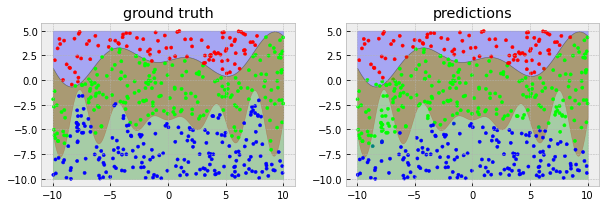

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[0].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[0].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[0].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = data_test['y'], s = 10)
ax[0].set_title('ground truth')

ax[1].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[1].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[1].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[1].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = labels_pred, s =10)
ax[1].set_title('predictions')

In [9]:
n_pts = 20000
cloud = np.random.uniform(low=0, high = 1, size = (n_pts, 2))
cloud[:, 0] = cloud[:, 0]*(xmax - xmin) + xmin
cloud[:, 1] = cloud[:, 1]*(ymax - ymin) + ymin

cloud_pred = model(torch.tensor(cloud).float().to(model.device)).detach().numpy()
cloud_labels = label_pts(cloud)

Text(0.5, 1.0, 'predictions')

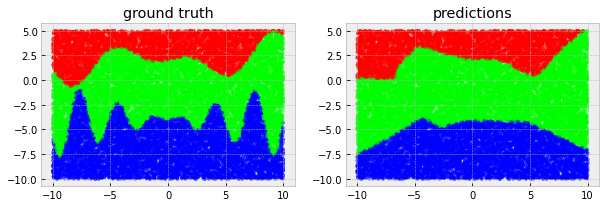

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred, s =10, alpha = .5)
ax[1].set_title('predictions')

# Approach 1

To obtain better results, we adopt the following approach :

During each training iteration, we keep track of the elements where the error on the confidence score is superior to a constant threshold and add it to a queue.

$$|1 - \mathbb{P}(\hat{y}/x)| > 1 - \epsilon$$

Afterwards, we sample points on the neighborhood of this set and generate their corresponding labels.

Finally, this new dataset is used to fit the model before going to the nex epoch.

In [11]:
model2 = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model2.device = 'cpu'
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3)
metrics2 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))

  0%|          | 1/300 [00:00<01:45,  2.84it/s]

epoch : 0 - L_train : 0.012896428028742472 - L_val : 0.012325952529907227


 17%|█▋        | 51/300 [00:09<00:44,  5.63it/s]

epoch : 50 - L_train : 0.010395581444104513 - L_val : 0.010783134341239928


 34%|███▎      | 101/300 [00:22<00:48,  4.12it/s]

epoch : 100 - L_train : 0.010943123579025268 - L_val : 0.010980136036872864


 50%|█████     | 151/300 [00:34<00:38,  3.90it/s]

epoch : 150 - L_train : 0.010617356856664022 - L_val : 0.010839138388633728


 67%|██████▋   | 201/300 [00:47<00:24,  4.00it/s]

epoch : 200 - L_train : 0.010662755449612935 - L_val : 0.010573184847831726


 84%|████████▎ | 251/300 [00:59<00:11,  4.39it/s]

epoch : 250 - L_train : 0.0103572016954422 - L_val : 0.010712604522705078


  0%|          | 0/400 [00:00<?, ?it/s]

Done training.


  0%|          | 1/400 [00:00<01:27,  4.59it/s]

epoch : 0 - L_train : 0.01009487016995748 - L_val : 0.010687869787216187


 13%|█▎        | 51/400 [00:14<01:31,  3.80it/s]

epoch : 50 - L_train : 0.009902971108754476 - L_val : 0.010601505160331726


 25%|██▌       | 101/400 [00:27<01:10,  4.26it/s]

epoch : 100 - L_train : 0.009875236511230468 - L_val : 0.010657027721405029


 38%|███▊      | 151/400 [00:42<01:13,  3.39it/s]

epoch : 150 - L_train : 0.009879846413930258 - L_val : 0.010659600853919983


 50%|█████     | 201/400 [00:55<00:48,  4.09it/s]

epoch : 200 - L_train : 0.00986960498491923 - L_val : 0.010650492668151856


 63%|██████▎   | 251/400 [01:21<01:16,  1.95it/s]

epoch : 250 - L_train : 0.009858398914337159 - L_val : 0.010679378986358642


 75%|███████▌  | 301/400 [01:33<00:21,  4.55it/s]

epoch : 300 - L_train : 0.00983391801516215 - L_val : 0.010693878412246704


 88%|████████▊ | 351/400 [01:44<00:09,  5.08it/s]

epoch : 350 - L_train : 0.009910825729370118 - L_val : 0.0107143794298172


100%|██████████| 400/400 [01:55<00:00,  3.48it/s]

Done training.


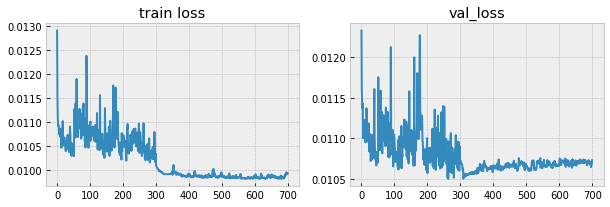

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Text(0.5, 1.0, 'segmentation mask with active learning')

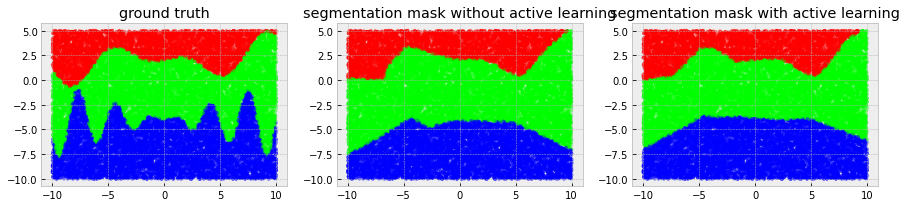

In [13]:
cloud_pred2 = model2(torch.tensor(cloud).float().to(model2.device)).detach().numpy()

fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred, s =10, alpha = .5)
ax[1].set_title('segmentation mask without active learning')

ax[2].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred2, s =10, alpha = .5)
ax[2].set_title('segmentation mask with active learning')


In [14]:
u = joblib.load('aug.pt')

u.keys()

dict_keys(['x', 'y'])

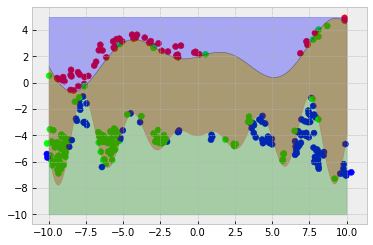

In [15]:
plt.scatter(u['x'][:, 0], u['x'][:, 1], c = u['y'])
plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)